In [800]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [1049]:
class ImagesDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = transforms.ToTensor()(img)
        img.close()
        return item.view(64 * 64)

    def __len__(self):
        return 1000 #len(self.img_names)

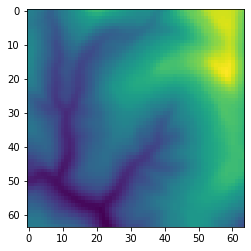

In [1050]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [1051]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [1055]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_linear_1 = nn.Linear(64 * 64, 1024)
        self.enc_linear_2 = nn.Linear(1024, 512)
        self.enc_linear_3_1 = nn.Linear(512, 128)
        self.enc_linear_3_2 = nn.Linear(512, 128)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(128, 512)
        self.dec_linear_2 = nn.Linear(512, 1024)
        self.dec_linear_3 = nn.Linear(1024, 64 * 64)
        
    def encode(self, data):
        x = F.relu(self.enc_linear_1(data))
        x = F.relu(self.enc_linear_2(x))
        return self.enc_linear_3_1(x), self.enc_linear_3_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = F.relu(self.dec_linear_2(out))
        out = torch.sigmoid(self.dec_linear_3(out))
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [1056]:
vae = VAE().cuda()

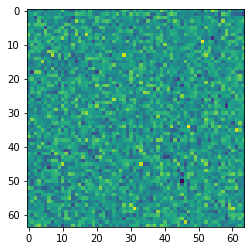

In [1057]:
x = dataset[400].cuda()
out, _, _ = vae(x)
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [1058]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 10000

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(8535.4395, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2, loss=tensor(6642.7944, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3, loss=tensor(6876.0107, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4, loss=tensor(6681.4614, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5, loss=tensor(5542.7422, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6, loss=tensor(7104.1401, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7, loss=tensor(5870.5996, device='cuda:0', grad_fn=<AddBackward0>)
epoch=8, loss=tensor(5967.9849, device='cuda:0', grad_fn=<AddBackward0>)
epoch=9, loss=tensor(5683.5581, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(5313.0352, device='cuda:0', grad_fn=<AddBackward0>)
epoch=11, loss=tensor(4855.8569, device='cuda:0', grad_fn=<AddBackward0>)
epoch=12, loss=tensor(4617.4062, device='cuda:0', grad_fn=<AddBackward0>)
epoch=13, loss=tensor(4680.6504, device='cuda:0', grad_fn=<AddBackward0>)
epoch=14, loss=tensor(5145.7983, device='cuda:0

epoch=112, loss=tensor(2318.2612, device='cuda:0', grad_fn=<AddBackward0>)
epoch=113, loss=tensor(2683.7556, device='cuda:0', grad_fn=<AddBackward0>)
epoch=114, loss=tensor(2730.1074, device='cuda:0', grad_fn=<AddBackward0>)
epoch=115, loss=tensor(2931.3857, device='cuda:0', grad_fn=<AddBackward0>)
epoch=116, loss=tensor(2666.2869, device='cuda:0', grad_fn=<AddBackward0>)
epoch=117, loss=tensor(2545.8413, device='cuda:0', grad_fn=<AddBackward0>)
epoch=118, loss=tensor(2654.7708, device='cuda:0', grad_fn=<AddBackward0>)
epoch=119, loss=tensor(2821.3540, device='cuda:0', grad_fn=<AddBackward0>)
epoch=120, loss=tensor(2775.1958, device='cuda:0', grad_fn=<AddBackward0>)
epoch=121, loss=tensor(2576.4521, device='cuda:0', grad_fn=<AddBackward0>)
epoch=122, loss=tensor(2313.1631, device='cuda:0', grad_fn=<AddBackward0>)
epoch=123, loss=tensor(2680.2520, device='cuda:0', grad_fn=<AddBackward0>)
epoch=124, loss=tensor(2396.0071, device='cuda:0', grad_fn=<AddBackward0>)
epoch=125, loss=tensor(24

epoch=222, loss=tensor(2108.1335, device='cuda:0', grad_fn=<AddBackward0>)
epoch=223, loss=tensor(2249.1550, device='cuda:0', grad_fn=<AddBackward0>)
epoch=224, loss=tensor(1975.5808, device='cuda:0', grad_fn=<AddBackward0>)
epoch=225, loss=tensor(1981.0784, device='cuda:0', grad_fn=<AddBackward0>)
epoch=226, loss=tensor(2045.3093, device='cuda:0', grad_fn=<AddBackward0>)
epoch=227, loss=tensor(1989.3033, device='cuda:0', grad_fn=<AddBackward0>)
epoch=228, loss=tensor(2332.4949, device='cuda:0', grad_fn=<AddBackward0>)
epoch=229, loss=tensor(2111.2266, device='cuda:0', grad_fn=<AddBackward0>)
epoch=230, loss=tensor(2211.2930, device='cuda:0', grad_fn=<AddBackward0>)
epoch=231, loss=tensor(2008.7476, device='cuda:0', grad_fn=<AddBackward0>)
epoch=232, loss=tensor(1828.2734, device='cuda:0', grad_fn=<AddBackward0>)
epoch=233, loss=tensor(2284.9841, device='cuda:0', grad_fn=<AddBackward0>)
epoch=234, loss=tensor(2240.4592, device='cuda:0', grad_fn=<AddBackward0>)
epoch=235, loss=tensor(17

epoch=332, loss=tensor(1633.1079, device='cuda:0', grad_fn=<AddBackward0>)
epoch=333, loss=tensor(1793.1794, device='cuda:0', grad_fn=<AddBackward0>)
epoch=334, loss=tensor(1709.0375, device='cuda:0', grad_fn=<AddBackward0>)
epoch=335, loss=tensor(1789.4460, device='cuda:0', grad_fn=<AddBackward0>)
epoch=336, loss=tensor(1770.0820, device='cuda:0', grad_fn=<AddBackward0>)
epoch=337, loss=tensor(1655.6792, device='cuda:0', grad_fn=<AddBackward0>)
epoch=338, loss=tensor(1638.3835, device='cuda:0', grad_fn=<AddBackward0>)
epoch=339, loss=tensor(1782.0464, device='cuda:0', grad_fn=<AddBackward0>)
epoch=340, loss=tensor(1773.7913, device='cuda:0', grad_fn=<AddBackward0>)
epoch=341, loss=tensor(1724.9984, device='cuda:0', grad_fn=<AddBackward0>)
epoch=342, loss=tensor(1866.3362, device='cuda:0', grad_fn=<AddBackward0>)
epoch=343, loss=tensor(2032.5747, device='cuda:0', grad_fn=<AddBackward0>)
epoch=344, loss=tensor(1373.5605, device='cuda:0', grad_fn=<AddBackward0>)
epoch=345, loss=tensor(18

epoch=442, loss=tensor(1548.6990, device='cuda:0', grad_fn=<AddBackward0>)
epoch=443, loss=tensor(1486.5132, device='cuda:0', grad_fn=<AddBackward0>)
epoch=444, loss=tensor(1628.6324, device='cuda:0', grad_fn=<AddBackward0>)
epoch=445, loss=tensor(1667.1194, device='cuda:0', grad_fn=<AddBackward0>)
epoch=446, loss=tensor(1518.4307, device='cuda:0', grad_fn=<AddBackward0>)
epoch=447, loss=tensor(1768.3550, device='cuda:0', grad_fn=<AddBackward0>)
epoch=448, loss=tensor(1608.2062, device='cuda:0', grad_fn=<AddBackward0>)
epoch=449, loss=tensor(1720.3699, device='cuda:0', grad_fn=<AddBackward0>)
epoch=450, loss=tensor(1554.0093, device='cuda:0', grad_fn=<AddBackward0>)
epoch=451, loss=tensor(1622.6493, device='cuda:0', grad_fn=<AddBackward0>)
epoch=452, loss=tensor(1774.3781, device='cuda:0', grad_fn=<AddBackward0>)
epoch=453, loss=tensor(1766.9094, device='cuda:0', grad_fn=<AddBackward0>)
epoch=454, loss=tensor(1638.8770, device='cuda:0', grad_fn=<AddBackward0>)
epoch=455, loss=tensor(15

epoch=552, loss=tensor(1625.6038, device='cuda:0', grad_fn=<AddBackward0>)
epoch=553, loss=tensor(1420.7736, device='cuda:0', grad_fn=<AddBackward0>)
epoch=554, loss=tensor(1609.5636, device='cuda:0', grad_fn=<AddBackward0>)
epoch=555, loss=tensor(1571.8777, device='cuda:0', grad_fn=<AddBackward0>)
epoch=556, loss=tensor(1479.4226, device='cuda:0', grad_fn=<AddBackward0>)
epoch=557, loss=tensor(1588.4292, device='cuda:0', grad_fn=<AddBackward0>)
epoch=558, loss=tensor(1580.1941, device='cuda:0', grad_fn=<AddBackward0>)
epoch=559, loss=tensor(1400.4447, device='cuda:0', grad_fn=<AddBackward0>)
epoch=560, loss=tensor(1391.2191, device='cuda:0', grad_fn=<AddBackward0>)
epoch=561, loss=tensor(1406.9697, device='cuda:0', grad_fn=<AddBackward0>)
epoch=562, loss=tensor(1442.0244, device='cuda:0', grad_fn=<AddBackward0>)
epoch=563, loss=tensor(1519.1091, device='cuda:0', grad_fn=<AddBackward0>)
epoch=564, loss=tensor(1414.5779, device='cuda:0', grad_fn=<AddBackward0>)
epoch=565, loss=tensor(16

epoch=662, loss=tensor(1581.1116, device='cuda:0', grad_fn=<AddBackward0>)
epoch=663, loss=tensor(1401.8323, device='cuda:0', grad_fn=<AddBackward0>)
epoch=664, loss=tensor(1246.5278, device='cuda:0', grad_fn=<AddBackward0>)
epoch=665, loss=tensor(1384.3810, device='cuda:0', grad_fn=<AddBackward0>)
epoch=666, loss=tensor(1454.1533, device='cuda:0', grad_fn=<AddBackward0>)
epoch=667, loss=tensor(1453.3073, device='cuda:0', grad_fn=<AddBackward0>)
epoch=668, loss=tensor(1441.3320, device='cuda:0', grad_fn=<AddBackward0>)
epoch=669, loss=tensor(1534.5178, device='cuda:0', grad_fn=<AddBackward0>)
epoch=670, loss=tensor(1580.9662, device='cuda:0', grad_fn=<AddBackward0>)
epoch=671, loss=tensor(1452.2391, device='cuda:0', grad_fn=<AddBackward0>)
epoch=672, loss=tensor(1485.3867, device='cuda:0', grad_fn=<AddBackward0>)
epoch=673, loss=tensor(1475.9641, device='cuda:0', grad_fn=<AddBackward0>)
epoch=674, loss=tensor(1473.7758, device='cuda:0', grad_fn=<AddBackward0>)
epoch=675, loss=tensor(14

epoch=772, loss=tensor(1401.7627, device='cuda:0', grad_fn=<AddBackward0>)
epoch=773, loss=tensor(1395.2677, device='cuda:0', grad_fn=<AddBackward0>)
epoch=774, loss=tensor(1298.2445, device='cuda:0', grad_fn=<AddBackward0>)
epoch=775, loss=tensor(1280.9818, device='cuda:0', grad_fn=<AddBackward0>)
epoch=776, loss=tensor(1437.8193, device='cuda:0', grad_fn=<AddBackward0>)
epoch=777, loss=tensor(1343.1575, device='cuda:0', grad_fn=<AddBackward0>)
epoch=778, loss=tensor(1415.5129, device='cuda:0', grad_fn=<AddBackward0>)
epoch=779, loss=tensor(1367.3684, device='cuda:0', grad_fn=<AddBackward0>)
epoch=780, loss=tensor(1339.6132, device='cuda:0', grad_fn=<AddBackward0>)
epoch=781, loss=tensor(1352.9619, device='cuda:0', grad_fn=<AddBackward0>)
epoch=782, loss=tensor(1318.1538, device='cuda:0', grad_fn=<AddBackward0>)
epoch=783, loss=tensor(1320.6611, device='cuda:0', grad_fn=<AddBackward0>)
epoch=784, loss=tensor(1387.3971, device='cuda:0', grad_fn=<AddBackward0>)
epoch=785, loss=tensor(13

epoch=882, loss=tensor(1335.8965, device='cuda:0', grad_fn=<AddBackward0>)
epoch=883, loss=tensor(1247.5325, device='cuda:0', grad_fn=<AddBackward0>)
epoch=884, loss=tensor(1269.0942, device='cuda:0', grad_fn=<AddBackward0>)
epoch=885, loss=tensor(1205.6597, device='cuda:0', grad_fn=<AddBackward0>)
epoch=886, loss=tensor(1210.2664, device='cuda:0', grad_fn=<AddBackward0>)
epoch=887, loss=tensor(1360.2649, device='cuda:0', grad_fn=<AddBackward0>)
epoch=888, loss=tensor(1294.3491, device='cuda:0', grad_fn=<AddBackward0>)
epoch=889, loss=tensor(1245.8977, device='cuda:0', grad_fn=<AddBackward0>)
epoch=890, loss=tensor(1315.9104, device='cuda:0', grad_fn=<AddBackward0>)
epoch=891, loss=tensor(1071.8777, device='cuda:0', grad_fn=<AddBackward0>)
epoch=892, loss=tensor(1282.8478, device='cuda:0', grad_fn=<AddBackward0>)
epoch=893, loss=tensor(1317.3070, device='cuda:0', grad_fn=<AddBackward0>)
epoch=894, loss=tensor(1231.5847, device='cuda:0', grad_fn=<AddBackward0>)
epoch=895, loss=tensor(12

epoch=992, loss=tensor(1193.8320, device='cuda:0', grad_fn=<AddBackward0>)
epoch=993, loss=tensor(1150.6722, device='cuda:0', grad_fn=<AddBackward0>)
epoch=994, loss=tensor(1220.7908, device='cuda:0', grad_fn=<AddBackward0>)
epoch=995, loss=tensor(1201.8080, device='cuda:0', grad_fn=<AddBackward0>)
epoch=996, loss=tensor(1175.4166, device='cuda:0', grad_fn=<AddBackward0>)
epoch=997, loss=tensor(1143.4059, device='cuda:0', grad_fn=<AddBackward0>)
epoch=998, loss=tensor(1269.8281, device='cuda:0', grad_fn=<AddBackward0>)
epoch=999, loss=tensor(1211.7047, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1000, loss=tensor(1210.9275, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1001, loss=tensor(1180.6516, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1002, loss=tensor(1192.6788, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1003, loss=tensor(1146.3589, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1004, loss=tensor(1188.9880, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1005, loss=ten

epoch=1100, loss=tensor(1207.6460, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1101, loss=tensor(1074.5376, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1102, loss=tensor(1214.8311, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1103, loss=tensor(1105.8022, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1104, loss=tensor(1104.0747, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1105, loss=tensor(1097.5129, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1106, loss=tensor(1088.2531, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1107, loss=tensor(1113.5620, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1108, loss=tensor(1095.9128, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1109, loss=tensor(1235.3281, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1110, loss=tensor(1124.3650, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1111, loss=tensor(1072.3783, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1112, loss=tensor(1126.6460, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1113, 

epoch=1208, loss=tensor(1154.2759, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1209, loss=tensor(1083.8209, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1210, loss=tensor(1077.0378, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1211, loss=tensor(1094.3284, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1212, loss=tensor(1124.5380, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1213, loss=tensor(1139.5469, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1214, loss=tensor(1054.9263, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1215, loss=tensor(1102.8090, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1216, loss=tensor(1104.7903, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1217, loss=tensor(1097.3461, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1218, loss=tensor(1158.8333, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1219, loss=tensor(1223.5669, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1220, loss=tensor(1159.3311, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1221, 

epoch=1316, loss=tensor(1129.8984, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1317, loss=tensor(1114.7764, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1318, loss=tensor(1092.5857, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1319, loss=tensor(1015.0935, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1320, loss=tensor(1119.7019, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1321, loss=tensor(1026.7572, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1322, loss=tensor(1067.7964, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1323, loss=tensor(1082.8850, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1324, loss=tensor(1038.4558, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1325, loss=tensor(1108.4746, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1326, loss=tensor(1157.1195, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1327, loss=tensor(1038.9756, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1328, loss=tensor(1149.4673, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1329, 

epoch=1424, loss=tensor(1040.2246, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1425, loss=tensor(1120.1831, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1426, loss=tensor(1031.8771, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1427, loss=tensor(987.8870, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1428, loss=tensor(1117.2076, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1429, loss=tensor(1041.3567, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1430, loss=tensor(1087.8954, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1431, loss=tensor(1143.3337, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1432, loss=tensor(1152.0134, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1433, loss=tensor(1044.4594, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1434, loss=tensor(1085.7214, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1435, loss=tensor(1077.9634, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1436, loss=tensor(1028.9584, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1437, l

epoch=1532, loss=tensor(993.7346, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1533, loss=tensor(1070.4465, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1534, loss=tensor(1109.8843, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1535, loss=tensor(1037.3987, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1536, loss=tensor(993.3182, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1537, loss=tensor(1012.2970, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1538, loss=tensor(1011.1426, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1539, loss=tensor(1065.3704, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1540, loss=tensor(1004.5143, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1541, loss=tensor(1069.2086, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1542, loss=tensor(1058.3577, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1543, loss=tensor(1014.6253, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1544, loss=tensor(1098.6113, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1545, lo

epoch=1641, loss=tensor(1061.6184, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1642, loss=tensor(1032.6558, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1643, loss=tensor(1031.8448, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1644, loss=tensor(1058.8323, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1645, loss=tensor(897.5198, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1646, loss=tensor(958.1171, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1647, loss=tensor(968.1147, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1648, loss=tensor(1081.3994, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1649, loss=tensor(973.2231, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1650, loss=tensor(1022.3792, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1651, loss=tensor(1053.9611, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1652, loss=tensor(981.4519, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1653, loss=tensor(1037.0695, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1654, loss=

epoch=1750, loss=tensor(1067.2612, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1751, loss=tensor(1025.1578, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1752, loss=tensor(991.6664, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1753, loss=tensor(1009.8336, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1754, loss=tensor(1062.6863, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1755, loss=tensor(1020.7648, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1756, loss=tensor(1027.5576, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1757, loss=tensor(998.0693, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1758, loss=tensor(989.2345, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1759, loss=tensor(976.6750, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1760, loss=tensor(946.9182, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1761, loss=tensor(1007.3598, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1762, loss=tensor(944.7629, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1763, loss=t

epoch=1859, loss=tensor(1011.0497, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1860, loss=tensor(946.2395, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1861, loss=tensor(1093.3207, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1862, loss=tensor(979.9384, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1863, loss=tensor(1063.4559, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1864, loss=tensor(930.9812, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1865, loss=tensor(930.7524, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1866, loss=tensor(914.6580, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1867, loss=tensor(981.7985, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1868, loss=tensor(980.0781, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1869, loss=tensor(1035.5465, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1870, loss=tensor(991.0204, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1871, loss=tensor(939.7409, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1872, loss=tens

epoch=1968, loss=tensor(933.9131, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1969, loss=tensor(955.4128, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1970, loss=tensor(1012.5652, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1971, loss=tensor(965.9882, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1972, loss=tensor(980.4097, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1973, loss=tensor(946.6052, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1974, loss=tensor(998.5252, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1975, loss=tensor(961.8693, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1976, loss=tensor(926.0401, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1977, loss=tensor(989.3372, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1978, loss=tensor(946.4060, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1979, loss=tensor(967.0037, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1980, loss=tensor(927.5247, device='cuda:0', grad_fn=<AddBackward0>)
epoch=1981, loss=tensor(

epoch=2078, loss=tensor(931.2637, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2079, loss=tensor(951.3451, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2080, loss=tensor(975.1407, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2081, loss=tensor(963.9162, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2082, loss=tensor(1016.9109, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2083, loss=tensor(917.8907, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2084, loss=tensor(933.3063, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2085, loss=tensor(931.7438, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2086, loss=tensor(963.2061, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2087, loss=tensor(978.8513, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2088, loss=tensor(925.0243, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2089, loss=tensor(955.0541, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2090, loss=tensor(926.7617, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2091, loss=tensor(

epoch=2188, loss=tensor(988.1215, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2189, loss=tensor(969.5513, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2190, loss=tensor(991.9557, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2191, loss=tensor(1030.5084, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2192, loss=tensor(995.3390, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2193, loss=tensor(918.4775, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2194, loss=tensor(913.4910, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2195, loss=tensor(964.9438, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2196, loss=tensor(913.0317, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2197, loss=tensor(918.1018, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2198, loss=tensor(913.7499, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2199, loss=tensor(900.6414, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2200, loss=tensor(983.0538, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2201, loss=tensor(

epoch=2298, loss=tensor(937.2629, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2299, loss=tensor(919.9438, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2300, loss=tensor(931.4779, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2301, loss=tensor(980.3282, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2302, loss=tensor(951.4328, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2303, loss=tensor(935.7180, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2304, loss=tensor(877.2342, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2305, loss=tensor(936.7631, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2306, loss=tensor(909.2073, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2307, loss=tensor(963.6354, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2308, loss=tensor(913.7843, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2309, loss=tensor(945.1255, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2310, loss=tensor(913.8166, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2311, loss=tensor(9

epoch=2408, loss=tensor(883.5027, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2409, loss=tensor(962.9568, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2410, loss=tensor(967.4288, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2411, loss=tensor(915.2152, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2412, loss=tensor(968.2781, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2413, loss=tensor(959.2969, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2414, loss=tensor(937.5193, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2415, loss=tensor(925.0533, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2416, loss=tensor(964.7792, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2417, loss=tensor(894.4730, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2418, loss=tensor(888.3165, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2419, loss=tensor(877.5449, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2420, loss=tensor(929.5985, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2421, loss=tensor(9

epoch=2518, loss=tensor(902.6293, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2519, loss=tensor(943.2469, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2520, loss=tensor(887.6189, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2521, loss=tensor(923.5897, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2522, loss=tensor(908.0111, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2523, loss=tensor(903.0648, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2524, loss=tensor(874.4039, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2525, loss=tensor(894.6439, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2526, loss=tensor(895.7563, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2527, loss=tensor(927.8602, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2528, loss=tensor(939.4315, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2529, loss=tensor(915.6594, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2530, loss=tensor(944.6014, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2531, loss=tensor(8

epoch=2628, loss=tensor(937.3845, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2629, loss=tensor(928.4203, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2630, loss=tensor(961.8596, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2631, loss=tensor(891.2062, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2632, loss=tensor(926.9177, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2633, loss=tensor(925.3951, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2634, loss=tensor(847.0978, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2635, loss=tensor(935.6111, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2636, loss=tensor(932.3751, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2637, loss=tensor(855.6461, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2638, loss=tensor(890.8595, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2639, loss=tensor(900.5112, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2640, loss=tensor(899.4655, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2641, loss=tensor(9

epoch=2738, loss=tensor(883.2476, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2739, loss=tensor(925.0054, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2740, loss=tensor(901.7224, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2741, loss=tensor(867.2159, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2742, loss=tensor(867.0142, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2743, loss=tensor(903.3177, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2744, loss=tensor(912.8397, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2745, loss=tensor(874.1644, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2746, loss=tensor(906.4995, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2747, loss=tensor(853.3543, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2748, loss=tensor(902.8251, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2749, loss=tensor(895.3041, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2750, loss=tensor(874.9133, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2751, loss=tensor(9

epoch=2848, loss=tensor(873.6226, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2849, loss=tensor(863.0514, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2850, loss=tensor(911.6111, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2851, loss=tensor(908.6003, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2852, loss=tensor(853.7440, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2853, loss=tensor(926.9726, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2854, loss=tensor(890.4975, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2855, loss=tensor(878.8592, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2856, loss=tensor(912.4240, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2857, loss=tensor(907.9474, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2858, loss=tensor(836.2790, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2859, loss=tensor(880.2910, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2860, loss=tensor(929.7746, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2861, loss=tensor(8

epoch=2958, loss=tensor(860.9950, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2959, loss=tensor(858.0319, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2960, loss=tensor(871.5570, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2961, loss=tensor(855.4860, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2962, loss=tensor(881.3344, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2963, loss=tensor(879.6423, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2964, loss=tensor(851.9851, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2965, loss=tensor(850.7910, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2966, loss=tensor(856.4164, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2967, loss=tensor(880.6671, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2968, loss=tensor(903.3540, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2969, loss=tensor(930.3436, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2970, loss=tensor(895.7344, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2971, loss=tensor(8

epoch=3068, loss=tensor(903.0885, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3069, loss=tensor(856.5121, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3070, loss=tensor(884.4701, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3071, loss=tensor(887.8701, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3072, loss=tensor(868.8352, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3073, loss=tensor(847.6360, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3074, loss=tensor(859.7137, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3075, loss=tensor(860.1686, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3076, loss=tensor(830.7570, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3077, loss=tensor(853.7067, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3078, loss=tensor(893.3967, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3079, loss=tensor(898.3696, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3080, loss=tensor(877.6986, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3081, loss=tensor(9

epoch=3178, loss=tensor(836.6506, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3179, loss=tensor(873.8220, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3180, loss=tensor(855.0940, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3181, loss=tensor(881.7500, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3182, loss=tensor(909.1390, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3183, loss=tensor(846.8853, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3184, loss=tensor(864.3218, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3185, loss=tensor(847.6362, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3186, loss=tensor(859.2554, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3187, loss=tensor(832.7052, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3188, loss=tensor(881.3579, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3189, loss=tensor(861.0419, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3190, loss=tensor(846.4587, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3191, loss=tensor(8

epoch=3288, loss=tensor(810.6511, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3289, loss=tensor(842.9526, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3290, loss=tensor(837.8734, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3291, loss=tensor(836.6536, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3292, loss=tensor(873.3129, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3293, loss=tensor(907.6785, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3294, loss=tensor(852.8158, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3295, loss=tensor(819.3940, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3296, loss=tensor(887.7462, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3297, loss=tensor(927.8868, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3298, loss=tensor(875.0937, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3299, loss=tensor(826.9836, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3300, loss=tensor(845.6248, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3301, loss=tensor(8

epoch=3398, loss=tensor(825.9548, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3399, loss=tensor(872.2867, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3400, loss=tensor(867.0062, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3401, loss=tensor(868.8250, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3402, loss=tensor(865.3742, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3403, loss=tensor(838.6396, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3404, loss=tensor(806.8173, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3405, loss=tensor(867.4138, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3406, loss=tensor(862.9316, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3407, loss=tensor(842.7972, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3408, loss=tensor(826.1440, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3409, loss=tensor(840.0319, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3410, loss=tensor(835.2032, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3411, loss=tensor(8

epoch=3508, loss=tensor(904.2966, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3509, loss=tensor(854.2423, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3510, loss=tensor(851.4330, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3511, loss=tensor(889.3701, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3512, loss=tensor(848.6137, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3513, loss=tensor(790.9259, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3514, loss=tensor(854.1504, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3515, loss=tensor(820.4409, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3516, loss=tensor(823.9280, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3517, loss=tensor(864.7371, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3518, loss=tensor(856.8802, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3519, loss=tensor(837.5581, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3520, loss=tensor(841.1211, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3521, loss=tensor(8

epoch=3618, loss=tensor(849.2230, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3619, loss=tensor(848.6509, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3620, loss=tensor(837.6589, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3621, loss=tensor(909.6115, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3622, loss=tensor(844.0937, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3623, loss=tensor(808.7173, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3624, loss=tensor(834.9708, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3625, loss=tensor(807.5273, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3626, loss=tensor(822.6948, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3627, loss=tensor(794.4894, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3628, loss=tensor(845.0307, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3629, loss=tensor(839.9294, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3630, loss=tensor(872.4312, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3631, loss=tensor(8

epoch=3728, loss=tensor(848.8367, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3729, loss=tensor(851.0054, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3730, loss=tensor(824.7418, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3731, loss=tensor(813.6249, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3732, loss=tensor(794.9615, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3733, loss=tensor(802.9690, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3734, loss=tensor(838.7254, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3735, loss=tensor(826.6339, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3736, loss=tensor(830.1494, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3737, loss=tensor(869.9955, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3738, loss=tensor(780.9229, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3739, loss=tensor(842.9036, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3740, loss=tensor(803.3938, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3741, loss=tensor(8

epoch=3838, loss=tensor(809.3007, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3839, loss=tensor(846.1099, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3840, loss=tensor(790.5351, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3841, loss=tensor(858.5320, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3842, loss=tensor(820.7775, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3843, loss=tensor(800.0325, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3844, loss=tensor(890.4373, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3845, loss=tensor(816.9228, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3846, loss=tensor(795.0894, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3847, loss=tensor(822.4507, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3848, loss=tensor(850.3113, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3849, loss=tensor(850.5637, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3850, loss=tensor(851.4579, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3851, loss=tensor(8

epoch=3948, loss=tensor(789.5982, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3949, loss=tensor(780.7548, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3950, loss=tensor(788.5895, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3951, loss=tensor(763.9691, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3952, loss=tensor(828.4324, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3953, loss=tensor(807.4608, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3954, loss=tensor(828.7821, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3955, loss=tensor(812.2363, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3956, loss=tensor(862.4049, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3957, loss=tensor(822.3961, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3958, loss=tensor(806.6795, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3959, loss=tensor(838.5021, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3960, loss=tensor(807.8933, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3961, loss=tensor(8

epoch=4058, loss=tensor(791.3264, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4059, loss=tensor(856.8136, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4060, loss=tensor(816.9643, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4061, loss=tensor(851.4252, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4062, loss=tensor(828.2482, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4063, loss=tensor(821.9998, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4064, loss=tensor(863.6321, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4065, loss=tensor(864.2078, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4066, loss=tensor(827.1693, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4067, loss=tensor(815.0646, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4068, loss=tensor(827.0721, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4069, loss=tensor(814.6109, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4070, loss=tensor(853.2828, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4071, loss=tensor(8

epoch=4168, loss=tensor(809.3885, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4169, loss=tensor(799.7050, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4170, loss=tensor(830.7451, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4171, loss=tensor(824.8637, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4172, loss=tensor(799.3088, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4173, loss=tensor(831.3416, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4174, loss=tensor(804.1772, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4175, loss=tensor(796.1166, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4176, loss=tensor(784.4431, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4177, loss=tensor(794.9910, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4178, loss=tensor(798.2761, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4179, loss=tensor(810.6425, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4180, loss=tensor(858.8019, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4181, loss=tensor(8

epoch=4278, loss=tensor(821.3907, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4279, loss=tensor(825.7046, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4280, loss=tensor(807.9977, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4281, loss=tensor(807.9688, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4282, loss=tensor(812.4562, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4283, loss=tensor(824.8639, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4284, loss=tensor(799.7302, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4285, loss=tensor(778.9938, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4286, loss=tensor(855.6434, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4287, loss=tensor(830.1672, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4288, loss=tensor(765.3773, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4289, loss=tensor(781.8138, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4290, loss=tensor(793.0620, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4291, loss=tensor(8

epoch=4388, loss=tensor(789.9215, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4389, loss=tensor(796.4919, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4390, loss=tensor(776.8037, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4391, loss=tensor(751.5801, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4392, loss=tensor(822.7825, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4393, loss=tensor(778.9998, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4394, loss=tensor(782.6877, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4395, loss=tensor(793.2185, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4396, loss=tensor(801.6667, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4397, loss=tensor(776.2352, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4398, loss=tensor(797.4020, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4399, loss=tensor(837.3352, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4400, loss=tensor(779.9489, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4401, loss=tensor(7

epoch=4498, loss=tensor(822.2911, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4499, loss=tensor(799.3010, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4500, loss=tensor(809.0170, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4501, loss=tensor(824.9363, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4502, loss=tensor(800.1210, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4503, loss=tensor(816.0849, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4504, loss=tensor(794.8347, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4505, loss=tensor(810.5031, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4506, loss=tensor(813.7899, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4507, loss=tensor(850.2313, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4508, loss=tensor(801.0686, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4509, loss=tensor(797.6732, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4510, loss=tensor(800.2719, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4511, loss=tensor(7

epoch=4608, loss=tensor(769.0340, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4609, loss=tensor(789.3684, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4610, loss=tensor(826.2380, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4611, loss=tensor(773.4107, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4612, loss=tensor(758.7418, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4613, loss=tensor(779.2263, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4614, loss=tensor(799.0499, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4615, loss=tensor(790.8326, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4616, loss=tensor(805.8538, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4617, loss=tensor(805.8642, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4618, loss=tensor(823.5420, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4619, loss=tensor(847.9435, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4620, loss=tensor(822.8342, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4621, loss=tensor(7

epoch=4718, loss=tensor(828.0643, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4719, loss=tensor(789.1782, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4720, loss=tensor(773.8235, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4721, loss=tensor(816.5822, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4722, loss=tensor(775.9880, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4723, loss=tensor(796.2373, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4724, loss=tensor(801.7770, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4725, loss=tensor(786.5902, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4726, loss=tensor(762.3593, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4727, loss=tensor(762.5824, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4728, loss=tensor(850.1874, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4729, loss=tensor(823.1662, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4730, loss=tensor(779.8917, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4731, loss=tensor(8

epoch=4828, loss=tensor(786.4357, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4829, loss=tensor(850.7697, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4830, loss=tensor(800.5798, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4831, loss=tensor(786.8635, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4832, loss=tensor(795.9844, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4833, loss=tensor(769.3867, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4834, loss=tensor(769.7424, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4835, loss=tensor(807.5936, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4836, loss=tensor(784.2673, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4837, loss=tensor(804.4426, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4838, loss=tensor(807.7062, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4839, loss=tensor(824.9641, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4840, loss=tensor(822.0931, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4841, loss=tensor(8

epoch=4938, loss=tensor(820.4379, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4939, loss=tensor(751.0912, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4940, loss=tensor(767.3796, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4941, loss=tensor(795.7344, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4942, loss=tensor(768.5079, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4943, loss=tensor(805.7940, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4944, loss=tensor(765.4181, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4945, loss=tensor(804.1211, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4946, loss=tensor(805.8470, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4947, loss=tensor(786.4692, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4948, loss=tensor(791.6921, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4949, loss=tensor(814.2798, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4950, loss=tensor(790.7426, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4951, loss=tensor(8

epoch=5048, loss=tensor(810.2463, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5049, loss=tensor(793.1924, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5050, loss=tensor(815.2692, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5051, loss=tensor(821.4153, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5052, loss=tensor(779.9061, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5053, loss=tensor(807.4846, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5054, loss=tensor(777.0690, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5055, loss=tensor(783.9941, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5056, loss=tensor(755.2096, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5057, loss=tensor(748.9222, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5058, loss=tensor(800.8171, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5059, loss=tensor(761.5719, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5060, loss=tensor(779.8812, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5061, loss=tensor(7

epoch=5158, loss=tensor(764.1310, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5159, loss=tensor(759.6417, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5160, loss=tensor(781.9664, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5161, loss=tensor(808.6380, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5162, loss=tensor(803.2086, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5163, loss=tensor(793.4648, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5164, loss=tensor(809.4988, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5165, loss=tensor(790.7134, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5166, loss=tensor(812.1504, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5167, loss=tensor(790.6988, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5168, loss=tensor(786.2139, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5169, loss=tensor(806.7804, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5170, loss=tensor(770.0496, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5171, loss=tensor(8

epoch=5268, loss=tensor(797.1442, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5269, loss=tensor(800.3281, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5270, loss=tensor(771.6217, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5271, loss=tensor(731.7720, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5272, loss=tensor(808.2073, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5273, loss=tensor(792.2131, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5274, loss=tensor(821.9668, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5275, loss=tensor(814.0892, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5276, loss=tensor(772.0242, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5277, loss=tensor(777.9161, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5278, loss=tensor(775.3458, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5279, loss=tensor(807.4949, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5280, loss=tensor(804.6653, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5281, loss=tensor(8

epoch=5378, loss=tensor(783.9001, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5379, loss=tensor(750.3291, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5380, loss=tensor(775.6201, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5381, loss=tensor(819.3826, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5382, loss=tensor(785.3547, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5383, loss=tensor(778.4182, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5384, loss=tensor(769.3670, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5385, loss=tensor(810.1839, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5386, loss=tensor(778.8167, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5387, loss=tensor(725.4729, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5388, loss=tensor(799.7979, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5389, loss=tensor(775.3802, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5390, loss=tensor(796.6285, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5391, loss=tensor(7

epoch=5488, loss=tensor(805.8843, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5489, loss=tensor(812.5580, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5490, loss=tensor(778.5490, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5491, loss=tensor(767.5482, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5492, loss=tensor(805.4395, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5493, loss=tensor(776.2420, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5494, loss=tensor(773.0815, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5495, loss=tensor(768.8257, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5496, loss=tensor(757.4127, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5497, loss=tensor(796.5706, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5498, loss=tensor(773.1103, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5499, loss=tensor(764.3831, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5500, loss=tensor(791.3394, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5501, loss=tensor(7

epoch=5598, loss=tensor(803.1226, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5599, loss=tensor(792.0465, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5600, loss=tensor(773.9138, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5601, loss=tensor(808.7790, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5602, loss=tensor(794.3511, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5603, loss=tensor(778.4161, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5604, loss=tensor(767.3649, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5605, loss=tensor(781.0615, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5606, loss=tensor(748.9238, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5607, loss=tensor(775.8156, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5608, loss=tensor(755.3137, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5609, loss=tensor(807.0014, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5610, loss=tensor(748.4352, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5611, loss=tensor(7

epoch=5708, loss=tensor(764.7957, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5709, loss=tensor(821.3403, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5710, loss=tensor(756.1748, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5711, loss=tensor(773.3837, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5712, loss=tensor(745.3588, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5713, loss=tensor(743.2740, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5714, loss=tensor(753.5096, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5715, loss=tensor(784.4104, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5716, loss=tensor(786.9321, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5717, loss=tensor(777.6533, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5718, loss=tensor(783.7435, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5719, loss=tensor(765.3604, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5720, loss=tensor(823.9096, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5721, loss=tensor(7

epoch=5818, loss=tensor(767.4811, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5819, loss=tensor(772.3092, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5820, loss=tensor(757.2093, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5821, loss=tensor(799.9261, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5822, loss=tensor(756.5076, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5823, loss=tensor(761.3556, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5824, loss=tensor(809.1661, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5825, loss=tensor(733.4194, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5826, loss=tensor(795.2368, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5827, loss=tensor(762.2051, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5828, loss=tensor(732.0553, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5829, loss=tensor(725.6704, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5830, loss=tensor(779.5920, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5831, loss=tensor(7

epoch=5928, loss=tensor(750.5067, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5929, loss=tensor(753.4081, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5930, loss=tensor(761.9299, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5931, loss=tensor(792.7764, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5932, loss=tensor(770.2241, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5933, loss=tensor(789.0536, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5934, loss=tensor(748.8961, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5935, loss=tensor(776.4890, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5936, loss=tensor(726.0620, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5937, loss=tensor(750.1953, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5938, loss=tensor(765.6461, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5939, loss=tensor(766.9528, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5940, loss=tensor(770.8790, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5941, loss=tensor(8

epoch=6038, loss=tensor(780.8989, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6039, loss=tensor(731.9409, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6040, loss=tensor(777.2910, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6041, loss=tensor(774.5247, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6042, loss=tensor(780.9508, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6043, loss=tensor(738.3672, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6044, loss=tensor(754.3646, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6045, loss=tensor(743.0724, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6046, loss=tensor(793.2730, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6047, loss=tensor(724.6707, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6048, loss=tensor(787.9516, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6049, loss=tensor(790.8665, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6050, loss=tensor(781.8824, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6051, loss=tensor(7

epoch=6148, loss=tensor(784.7826, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6149, loss=tensor(801.5491, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6150, loss=tensor(748.9809, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6151, loss=tensor(780.2128, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6152, loss=tensor(764.3398, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6153, loss=tensor(758.0380, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6154, loss=tensor(797.8441, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6155, loss=tensor(725.5656, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6156, loss=tensor(739.9227, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6157, loss=tensor(767.5247, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6158, loss=tensor(785.5342, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6159, loss=tensor(772.1325, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6160, loss=tensor(746.8549, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6161, loss=tensor(7

epoch=6258, loss=tensor(764.5743, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6259, loss=tensor(744.6998, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6260, loss=tensor(742.8866, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6261, loss=tensor(766.1532, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6262, loss=tensor(771.9320, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6263, loss=tensor(747.3132, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6264, loss=tensor(765.2916, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6265, loss=tensor(715.1017, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6266, loss=tensor(715.9288, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6267, loss=tensor(802.2852, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6268, loss=tensor(742.7060, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6269, loss=tensor(789.0869, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6270, loss=tensor(710.2557, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6271, loss=tensor(7

epoch=6368, loss=tensor(735.4718, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6369, loss=tensor(762.0054, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6370, loss=tensor(725.5388, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6371, loss=tensor(748.2635, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6372, loss=tensor(754.7048, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6373, loss=tensor(723.5392, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6374, loss=tensor(710.2297, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6375, loss=tensor(764.6675, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6376, loss=tensor(754.0503, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6377, loss=tensor(784.0587, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6378, loss=tensor(723.7048, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6379, loss=tensor(755.0557, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6380, loss=tensor(748.0899, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6381, loss=tensor(7

epoch=6478, loss=tensor(785.9178, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6479, loss=tensor(727.3114, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6480, loss=tensor(756.2630, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6481, loss=tensor(737.6203, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6482, loss=tensor(780.5577, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6483, loss=tensor(785.5432, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6484, loss=tensor(748.6045, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6485, loss=tensor(789.0289, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6486, loss=tensor(768.5900, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6487, loss=tensor(769.5949, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6488, loss=tensor(741.6702, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6489, loss=tensor(761.6896, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6490, loss=tensor(759.6862, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6491, loss=tensor(7

epoch=6588, loss=tensor(740.1980, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6589, loss=tensor(765.5916, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6590, loss=tensor(775.8679, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6591, loss=tensor(719.0926, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6592, loss=tensor(763.8193, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6593, loss=tensor(738.1292, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6594, loss=tensor(719.4276, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6595, loss=tensor(756.6152, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6596, loss=tensor(750.2034, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6597, loss=tensor(760.3275, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6598, loss=tensor(703.1001, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6599, loss=tensor(762.2216, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6600, loss=tensor(820.0370, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6601, loss=tensor(7

epoch=6698, loss=tensor(740.5389, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6699, loss=tensor(777.9766, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6700, loss=tensor(753.9246, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6701, loss=tensor(763.8392, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6702, loss=tensor(743.5619, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6703, loss=tensor(760.2764, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6704, loss=tensor(762.0807, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6705, loss=tensor(762.6088, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6706, loss=tensor(769.6562, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6707, loss=tensor(751.8145, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6708, loss=tensor(754.4127, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6709, loss=tensor(779.7428, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6710, loss=tensor(734.1877, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6711, loss=tensor(7

epoch=6808, loss=tensor(746.4326, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6809, loss=tensor(723.4335, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6810, loss=tensor(756.8707, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6811, loss=tensor(756.2269, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6812, loss=tensor(793.5929, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6813, loss=tensor(714.1246, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6814, loss=tensor(741.8588, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6815, loss=tensor(718.5386, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6816, loss=tensor(760.5265, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6817, loss=tensor(741.7210, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6818, loss=tensor(755.4897, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6819, loss=tensor(771.4885, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6820, loss=tensor(780.0624, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6821, loss=tensor(7

epoch=6918, loss=tensor(740.7404, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6919, loss=tensor(781.9918, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6920, loss=tensor(740.1114, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6921, loss=tensor(770.0741, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6922, loss=tensor(723.7139, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6923, loss=tensor(754.5265, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6924, loss=tensor(737.8112, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6925, loss=tensor(771.2576, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6926, loss=tensor(751.1440, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6927, loss=tensor(748.5928, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6928, loss=tensor(754.4370, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6929, loss=tensor(770.5847, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6930, loss=tensor(766.2739, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6931, loss=tensor(7

epoch=7028, loss=tensor(788.3530, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7029, loss=tensor(744.2192, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7030, loss=tensor(756.2259, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7031, loss=tensor(750.3235, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7032, loss=tensor(760.2477, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7033, loss=tensor(740.4028, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7034, loss=tensor(731.8344, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7035, loss=tensor(721.8704, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7036, loss=tensor(728.7401, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7037, loss=tensor(738.4433, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7038, loss=tensor(746.1353, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7039, loss=tensor(756.3322, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7040, loss=tensor(812.0098, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7041, loss=tensor(7

epoch=7138, loss=tensor(778.9778, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7139, loss=tensor(721.4823, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7140, loss=tensor(765.1068, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7141, loss=tensor(762.3769, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7142, loss=tensor(753.8676, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7143, loss=tensor(773.9436, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7144, loss=tensor(773.0307, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7145, loss=tensor(716.1089, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7146, loss=tensor(764.9812, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7147, loss=tensor(764.4919, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7148, loss=tensor(753.7356, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7149, loss=tensor(746.5662, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7150, loss=tensor(733.3332, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7151, loss=tensor(7

epoch=7248, loss=tensor(785.3155, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7249, loss=tensor(742.5278, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7250, loss=tensor(743.5591, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7251, loss=tensor(736.0234, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7252, loss=tensor(755.3788, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7253, loss=tensor(757.9028, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7254, loss=tensor(742.8502, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7255, loss=tensor(737.3800, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7256, loss=tensor(766.5007, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7257, loss=tensor(764.4568, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7258, loss=tensor(746.4834, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7259, loss=tensor(748.1567, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7260, loss=tensor(740.8987, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7261, loss=tensor(7

epoch=7358, loss=tensor(734.3292, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7359, loss=tensor(814.7285, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7360, loss=tensor(721.5397, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7361, loss=tensor(738.9779, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7362, loss=tensor(729.2143, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7363, loss=tensor(779.9594, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7364, loss=tensor(758.0699, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7365, loss=tensor(752.2665, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7366, loss=tensor(757.3645, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7367, loss=tensor(731.8046, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7368, loss=tensor(747.1743, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7369, loss=tensor(707.4886, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7370, loss=tensor(733.6733, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7371, loss=tensor(7

epoch=7468, loss=tensor(700.7063, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

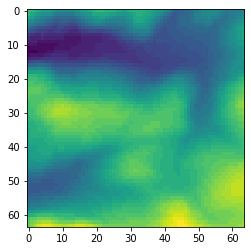

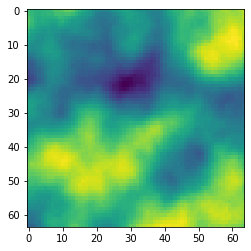

In [1089]:
x = dataset[200].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x)
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [1124]:
#torch.save(vae.state_dict(), './variational_autoencoder_save')

In [973]:
vae.load_state_dict(torch.load('./variational_autoencoder_save'))

<All keys matched successfully>

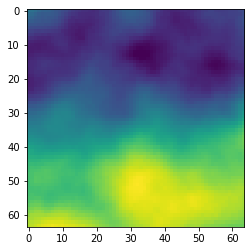

In [1132]:
# Generator
code = torch.FloatTensor(128).normal_()

out = vae.decode(code.cuda())
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()